In [1]:
import os
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchmetrics import Accuracy, MetricCollection, JaccardIndex, F1Score
import segmentation_models_pytorch as smp
from pytorch_toolbelt.losses import JaccardLoss, BinaryFocalLoss
from torch.utils.data import Dataset, random_split, DataLoader

from pytorch_lightning import Trainer
from typing import Any, Tuple, Optional, Callable, cast

import matplotlib.pyplot as plt
import wandb
import tqdm as notebook_tqdm
import random

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [3]:
import segmentation_models_pytorch as smp

In [4]:
pl.seed_everything(27)

Global seed set to 27


27

In [5]:
wandb.login()

wandb: Currently logged in as: sofstef (trees). Use `wandb login --relogin` to force relogin


True

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
%load_ext lab_black

In [8]:
os.chdir("/Users/sofija/Ai4er/mres/tree-segmentation")
os.getcwd()

'/Users/sofija/Ai4er/mres/tree-segmentation'

In [9]:
from src.datasets import TreeSegments
from src.evaluation import BinaryIoU
from src.datamodules import TreeDataModule
from src.models import UNet, SegModel
from src.evaluation import LogPredictionSamplesCallback

In [10]:
n_cpu = os.cpu_count()

In [11]:
dm = TreeDataModule(
    data_dir="data/train/samples/",
    target_dir="data/train/segments/",
    test_data_dir="data/test/samples",
    test_target_dir="data/test/segments/",
    batch_size=8,
    num_workers=0,
    drop_last_batch=True,
)

In [12]:
dm.setup(stage="fit")
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

In [30]:
for sample in train_dl:
    image = sample[0]
    mask = sample[1]

In [34]:
image.min()

tensor(-1.5401)

In [35]:
image.dtype

torch.float32

In [36]:
image.shape

torch.Size([8, 1, 128, 160])

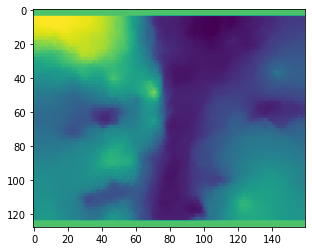

In [38]:
plt.imshow(torch.squeeze(image[0, :, :, :]))

## Setting up model training


In [13]:
model = SegModel(
    in_channels=1,
    encoder_name="resnet18",
    encoder_weights="imagenet",
    num_classes=1,
    loss="dice",
    ignore_zeros=None,
    lr=0.001,
    jaccard_average="macro",
)

In [14]:
callbacks = [
    ModelCheckpoint(monitor="train_accuracy", mode="max"),
    ModelCheckpoint(monitor="val_accuracy", mode="max"),
    ModelCheckpoint(monitor="train_jaccard", mode="max"),
    ModelCheckpoint(monitor="val_jaccard", mode="max"),
    LogPredictionSamplesCallback(),
    ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=2),
    ModelCheckpoint(monitor="train_f1", mode="max"),
    ModelCheckpoint(monitor="val_f1", mode="max"),
]

In [15]:
wandb_logger = WandbLogger(
    project="Trees",
    log_model="all",
    name="test_prediction_logging",
    save_code=False,
)

trainer = Trainer(
    logger=wandb_logger,
    callbacks=callbacks,
    # fast_dev_run=True,
    max_epochs=3,
)

wandb_logger.watch(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [16]:
trainer.fit(model=model, datamodule=dm)


   | Name       | Type             | Params
-------------------------------------------------
0  | net        | Unet             | 14.3 M
1  | loss       | DiceLoss         | 0     
2  | train_acc  | Accuracy         | 0     
3  | val_acc    | Accuracy         | 0     
4  | test_acc   | Accuracy         | 0     
5  | train_jacc | JaccardIndex     | 0     
6  | val_jacc   | JaccardIndex     | 0     
7  | test_jacc  | JaccardIndex     | 0     
8  | train_f1   | F1Score          | 0     
9  | val_f1     | F1Score          | 0     
10 | test_f1    | F1Score          | 0     
11 | rmse       | MeanSquaredError | 0     
-------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.288    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 11/14 [00:12<00:03,  1.15s/it, loss=0.558, v_num=d558]
Validation: 0it [00:00, ?it/s]
Epoch 1:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 11/14 [00:10<00:02,  1.06it/s, loss=0.444, v_num=d558]
Validation: 0it [00:00, ?it/s]
Epoch 2:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [47]:
d = {"one": 1}

In [49]:
d.keys()

dict_keys(['one'])

In [25]:
dm.setup(stage="test")
test_dl = dm.test_dataloader()

In [24]:
trainer.test(dataloaders=test_dl)

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1444: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /Users/sofija/Ai4er/mres/tree-segmentation/lightning_logs/version_50/checkpoints/epoch=4-step=5.ckpt
Loaded model weights from checkpoint at /Users/sofija/Ai4er/mres/tree-segmentation/lightning_logs/version_50/checkpoints/epoch=4-step=5.ckpt
/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` 

Testing DataLoader 0:   0%|                                                                                        | 0/1 [00:00<?, ?it/s]the shape of gtruth is torch.Size([1, 128, 160])
max of gtruth is 1
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
         test_f1            0.21215376257896423
      test_jaccard          0.20650112628936768
        test_loss           0.7835779786109924
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7835779786109924,
  'test_accuracy': 1.0,
  'test_jaccard': 0.20650112628936768,
  'test_f1': 0.21215376257896423}]

### Inspecting prediction

Automatically auto-loads the best weights from the previous run

```
predictions = trainer.predict(dataloaders=predict_dataloader)
```
Or call with pretrained model
```
model = MyLightningModule.load_from_checkpoint(PATH)
trainer = Trainer()
predictions = trainer.predict(model, dataloaders=test_dataloader)
```

In [210]:
dm.setup(stage="predict")

In [211]:
predict_dl = dm.predict_dataloader()

In [212]:
# currently in my predict dataloader I have only the inputs
# so below where I plot I pick the corresponding mask by hand

for sample in predict_dl:
    gtruth = sample[0]

In [213]:
gtruth.shape

torch.Size([1, 128, 160])

In [214]:
test_predict = trainer.predict(model, predict_dl)

Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [215]:
test_predict[0].shape

torch.Size([1, 128, 160])

In [218]:
pred = torch.squeeze(test_predict[0])

## Compute jaccard score for prediction and ground truth

In [54]:
from PIL import Image

In [55]:
from src.evaluation import BinaryIoU

In [226]:
pred.shape

torch.Size([128, 160])

In [227]:
gtruth = torch.squeeze(mask).int()

In [225]:
gtruth.shape

torch.Size([1, 128, 160])

In [57]:
from torchmetrics import Accuracy, MetricCollection, JaccardIndex, PrecisionRecallCurve

In [235]:
acc = Accuracy(num_classes=2)

In [236]:
acc(pred, gtruth)

tensor(0.8411)

(-0.5, 159.5, 127.5, -0.5)

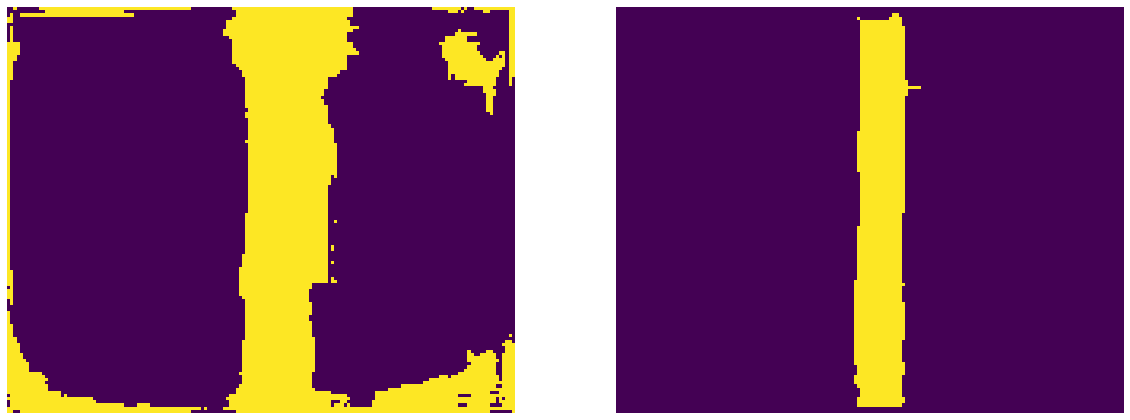

In [221]:
ncols = 2

sample_n = 0

fig, axs = plt.subplots(
    nrows=1,
    ncols=ncols,
    figsize=(20, ncols * 4),
)

# msk = test_predict[0][sample_n, :, :]
# msk = torch.squeeze(msk)
axs[0].imshow(pred)
axs[0].axis("off")

true_mask = torch.squeeze(mask)
axs[1].imshow(true_mask)
axs[1].axis("off")


# gtruth = Image.open("data/debug_segment/BinaryMask_22_47.tiff")
# axs[1].imshow(gtruth)

# plt.savefig("data/plots/one_sample.jpg")

In [17]:
wandb.finish()

epoch,▁▃▃▆▆█
train_accuracy,▁█▆
train_f1,▁▇█
train_jaccard,▁▇█
trainer/global_step,▁▁▁▃▃▃▃▃▃▃▃▃▃▂▂▂▆▆▆▆▆▆▆▆▆▆▂▃▃██
val_accuracy,█▁▁
val_f1,▁██
val_jaccard,▁██
val_loss_epoch,█▄▁
val_loss_step,▆▃█▃▂▇▁▁▆
epoch,3
